# Homework for chapter 4 in "Statistical Rethinking"

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from theano import shared

In [2]:
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Easy
### 4E1
The likelihood is defined by the first line in the model. The likelihood is the probability of observing the data, given the model parameters: $Pr(y_i|\mu, \sigma)$ (assuming that the y_i's are normally distributed with means at $\mu$ and standard deviation $\sigma$.

Computaitionally, in pymc3 this is stated as: 

`pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y_i)`

### 4E2
The posterior distribution, obtained above, depends on two factors: the mean and the standrad deviation. However, once obtained, this posterior distribution is constand and is not dependant on anything.

### 4E3
The full form of the bayes theoram for this model is:

$$Pr(\mu, \sigma | y_i) = \frac{Pr(y_i|\mu, \sigma)Pr(\mu)Pr(\sigma)} {\iint_{\mu, \sigma} \iint_V Pr(y_i|\mu, \sigma)Pr(\mu)Pr(\sigma), d\mu d\sigma} $$

where 

$$Pr(\mu) \sim \mathcal{N}(0, 10)$$
$$Pr(\sigma) \sim \mathcal{U}(0, 10)$$

### 4E4
The linear model is expressed in the following mathematical expression for the sample mean $\mu$:
$$\mu = \alpha + \beta x_i$$

### 4E5
In this second model the posterior probability depends on a sinlge parameter, which is the value of of $X_i$.

## Medium
### 4M1
Let's simulate a random normal distribution centered at $\mu=0$ with standard deviation of $\sigma=10$.
Also, simulate a random normal distribution between a=0 (`loc` parameter) and b=10 (`scale` parameter):

In [3]:
# number of samples to simulate
n = 10000

mu = stats.norm.rvs(loc=0, scale=10, size=n, random_state=770)
sigma = stats.uniform.rvs(loc=0, scale=10, size=n, random_state=770)

Plot the result:

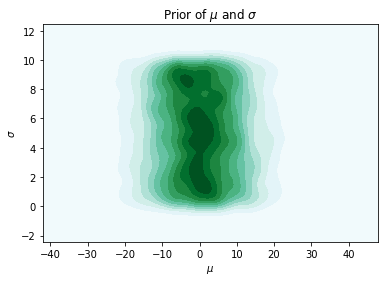

In [4]:
sns.kdeplot(mu, sigma, shade=True, cut=5)
plt.title('Prior of $\mu$ and $\sigma$');
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$');

### 4M2
Before actually writing the model, lets first load the data into a pandas dataframe. It is not required to do the homework, but it makes the code run - do we'll do it.

In [5]:
howell = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv', delimiter=';')

We can now write the model and find the MAP:

In [6]:
modM2 = pm.Model()

with modM2:

    # Priors for unknown model parameters
    mu = pm.Normal('mu', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=10)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=howell['height'])
    
"""we wern't asked for the maps, but we'll do it anyway"""
map_estimate = pm.find_MAP(model=modM2)
map_estimate

logp = -40,131, ||grad|| = 628.24: 100%|██████████| 15/15 [00:00<00:00, 1153.30it/s] 


{'mu': array(138.00990165137614),
 'sigma': array(10.0),
 'sigma_interval__': array(47.24961095868212)}

Some comments: I've doubles checked these MAP results using another optimizer, the downhill simplex algorithm, which is very robust. The results remained stable.

### 4M3
Unlike the previous model (modM2), this time, we have parameters.

In [7]:
modM3 = pm.Model()

with modM3:

    # Priors for unknown model parameters
    a = pm.Normal('a', mu=0, sd=50)
    b = pm.Uniform('b', lower=0, upper=10)
    mu = a + b*howell['weight'] # we can use 'Deterministic' here. It's makes printing results ugly.
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=howell['height'])

"""we wern't asked for the maps, but we'll do it anyway"""
map_estimate = pm.find_MAP(model=modM3)
map_estimate

logp = -1,999.9, ||grad|| = 0.090988: 100%|██████████| 43/43 [00:00<00:00, 1916.84it/s]  


{'a': array(75.40260746801697),
 'b': array(1.7650959696475712),
 'b_interval__': array(-1.5401766470432192),
 'sigma': array(9.345884963673246),
 'sigma_interval__': array(-1.4701639261899548)}

Note, that altough we've used a much wider unifrom prior for sigma this time, the map estimaes for sigma for both modM2 and modM3 are quite similar.

### 4M4
We want to write a model to predict the heights of students, based on previous measurement. The data in our disposal is the height of each student, measured once every year for three years.

To solve this problem is suggest: 

1. Each year, the height are normally distributed around some mean $\mu_{i}$.
2. With every passing year, students gain height by a certain constant "rate" $\beta$.
3. As a result, the heigh mean is shifted towards higher value every year.

Using mathematical formula, the expression for the height mean at year $y$ is:

$\mu_y = \mu_0 + rate*y$

observed_height = $\mathcal{N}(\mu_y, \sigma)$

#### Priors

1. $mu_0$ = N(mu=mean(height['year0'].mean(), sd=50). Explanation: Since $\mu_0$ is the intercept, it should reflect the mean height at $y=0$.
2. $b$ = N(mu=2, sd=50). Explanation: weak prior, assuming grouth of about 2cm/year. Comment about this: students always get heigher. This should always be positive. I could have used a b ~ U(0, 50), but for some reason I choose not to - but it might be better.
3. $\sigma$ = U(0, 100). Explenation: very weak prior, which is never negative. Assuming the varience in height is never more than 100 cm.

### 4M5
Altought every additional information should make us more certain about the initial conditins and therefore implies more informative priors, the initial height mean observation was already taken into account, also the fact that students also get higher.

### 4M6
If I would jave known that the variance of height amongst children of the same age is never more than 64, I could have chosen $\sigma$ = U(0, 64). Uniform distibution are useful for giving definate bounds.

## Hard
### 4H1


First, we need to build a model using the Howell1 data to predict height from weight. We'll use the model suggested by the book at R code 4.43. Actually, this is exactly lime modM3 above, with a slight twist of weight centering - which affects the intercept term `a`.

In [8]:
# center the weight
howell['weight_c'] = howell['weight'] - howell['weight'].mean()

In [9]:
modH1 = pm.Model()

with modH1:

    # Priors for unknown model parameters
    a = pm.Normal('a', mu=0, sd=50)
    b = pm.Uniform('b', lower=0, upper=10)
    mu = a + b*howell['weight'] # we can use 'Deterministic' here. It's makes printing results ugly.
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=howell['height'])

    trace_H1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:04<00:00, 490.94it/s]


In [10]:
trace_df = pm.trace_to_dataframe(trace_H1)
trace_df.mean()

a        75.479979
b         1.762540
sigma     9.377301
dtype: float64

In [11]:
trace_df.corr()

,a,b,sigma
a,1.000000,-0.925688,-0.025616
b,-0.925688,1.000000,0.021966
sigma,-0.025616,0.021966,1.000000


#### Predictions
Let's add the data to a DataFame and predict:

In [12]:
predictions = pd.DataFrame()
predictions['weight'] = pd.Series([46.95, 43.72, 64.78, 32.59, 54.63], dtype=np.float16)

In [13]:
weights_shared = shared(howell['weight'].values)

modH1 = pm.Model()

with modH1:

    # Priors for unknown model parameters
    a = pm.Normal('a', mu=0, sd=50)
    b = pm.Uniform('b', lower=0, upper=10)
    mu = a + b * weights_shared # we can use 'Deterministic' here. It's makes printing results ugly.
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=howell['height'])

    trace_H1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:04<00:00, 461.61it/s]


In [14]:
weights_shared.set_value(predictions['weight'].values)
posterior = pm.sample_ppc(trace=trace_H1, model=modH1, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1541.61it/s]


In [15]:
predictions['Expected height'] = np.mean(posterior['Y_obs'], axis=0)
predictions['lower 89%'] = pm.hpd(posterior['Y_obs'], alpha=0.11)[:, 0]
predictions['upper 89%'] = pm.hpd(posterior['Y_obs'], alpha=0.11)[:, 1]
predictions

,weight,Expected height,lower 89%,upper 89%
0,46.93750,158.550091,143.877551,172.798159
1,43.71875,152.827149,138.855247,167.385956
2,64.75000,189.513228,176.657602,206.466877
3,32.59375,132.320987,117.375429,146.878103
4,54.62500,172.105615,156.241307,186.977156


### 4H2


Let's select only the young population:

In [16]:
young_howell = howell.loc[howell.loc[:, 'age'] < 18, :]
print(young_howell.count())

height      192
weight      192
age         192
male        192
weight_c    192
dtype: int64


Fit a linear model. As a starting point, we'll just use the same definitions as before:

In [17]:
y_weight_shared = shared(young_howell['weight'].values)

modH2 = pm.Model()

with modH2:

    # Priors for unknown model parameters
    a = pm.Normal('a', mu=0, sd=50)
    b = pm.Uniform('b', lower=0, upper=10)
    mu = a + b * y_weight_shared 
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=young_howell['height'].values)

    trace_H2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:03<00:00, 521.26it/s]


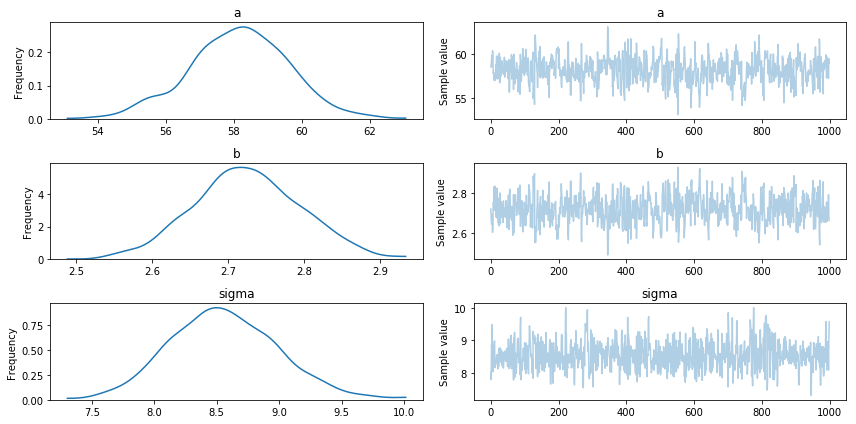

In [18]:
pm.traceplot(trace_H2);

In [19]:
trace_df = pm.trace_to_dataframe(trace_H2)
trace_df.mean()

a        58.130707
b         2.723706
sigma     8.555204
dtype: float64

The model predicts that for each additional Kg of weight, the child gains 2.7 cm in height. This rate is much higher than for whole population (in 4H1 the value of the same parameter `b` was 1.7). This increase is due to the fact that kids grow - and in this process, they ratio between weight/height changes.

In [20]:
y_weight_shared.set_value(np.arange(0, 50, 1))
postr_predic = pm.sample_ppc(trace=trace_H2, model=modH2, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1565.04it/s]


In [21]:
pred_df = pd.DataFrame()
pred_df['weight'] = y_weight_shared.get_value()
pred_df['prd_height'] = postr_predic['Y_obs'].mean(axis=0)
pred_df['l_conf'] = pm.hpd(postr_predic['Y_obs'], alpha=0.11)[:, 0]
pred_df['r_conf'] = pm.hpd(postr_predic['Y_obs'], alpha=0.11)[:, 1]

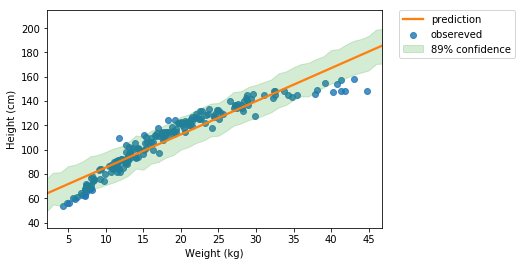

In [22]:
fig, ax = plt.subplots()
sns.regplot(young_howell['weight'], young_howell['height'], fit_reg=False, ax=ax, label='obsereved')
sns.regplot('weight', 'prd_height', data=pred_df, fit_reg=True, ax=ax, label='prediction', scatter=False)

plt.fill_between(pred_df['weight'], pred_df['l_conf'], pred_df['r_conf'], color='C2', alpha=0.2, 
                 interpolate=True, label='89% confidence')

plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Expectedly, the model results in a straight line, which cannot desribe the curved shape. Since the undelying data is obviously non-linear, additional terms must be added in order to provide a good description. Additionally, and this has nothing to do with statistics, the weights are very low. There isn't even a single observation above 45 kg.